# Imports

In [1]:
import pandas as pd

# Dataset Inspection

In [2]:
# Load the cleaned data
df = pd.read_csv('clean_df.csv')

# Display the first few rows of the DataFrame to verify it's loaded correctly
df.head(20)

,quantity,unit,ingredient,ingredient_step,recipe_id
0,45.0,ml,dark rum,0,0
1,22.5,ml,lime juice,1,0
2,15.0,ml,sugar,2,0
3,1.0,dash,angostura bitters,3,0
4,6.0,drop,pernod,4,0
5,240.0,ml,crushed ice,5,0
6,60.0,ml,silver tequila,0,1
7,22.5,ml,marie brizard crme de cacao,1,1
8,22.5,ml,lemon juice,2,1
9,45.0,ml,gin,0,2


In [3]:
df.tail(5)

,quantity,unit,ingredient,ingredient_step,recipe_id
2892,60.0,ml,rye whiskey,0,654
2893,22.5,ml,lemon juice,1,654
2894,22.5,ml,pineapple syrup,2,654
2895,15.0,ml,dolin blanc,3,654
2896,1.0,dash,orange bitters,4,654


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2897 entries, 0 to 2896
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   quantity         2584 non-null   float64
 1   unit             2520 non-null   object 
 2   ingredient       2896 non-null   object 
 3   ingredient_step  2897 non-null   int64  
 4   recipe_id        2897 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 113.3+ KB


# Decision Tree

In [5]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

def prepare_data(df):
    df['next_ingredient'] = df.groupby('recipe_id')['ingredient'].shift(-1).fillna('End')
    
    # Convert all ingredients to string to avoid type mismatch
    df['ingredient'] = df['ingredient'].astype(str)
    
    # Initialize the MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    
    # Apply the transformation
    ingredient_dummies = mlb.fit_transform(df['ingredient'].apply(lambda x: [x]))
    ingredient_df = pd.DataFrame(ingredient_dummies, columns=mlb.classes_)

    return ingredient_df, df['next_ingredient'], mlb

# Example usage (assuming 'df' is your DataFrame)
try:
    X, y, mlb = prepare_data(df)
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize and train the Decision Tree Classifier
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)
    
    # Function to generate a recipe sequence
    def generate_recipe(model, mlb, initial_ingredient):
        ingredients = [initial_ingredient]
        while True:
            current_setup = mlb.transform([ingredients[-1:]])
            next_ingredient = model.predict(current_setup)[0]
            if next_ingredient == 'End' or next_ingredient in ingredients:
                break
            ingredients.append(next_ingredient)
        return ingredients
    
    # Generate recipe example
    print(generate_recipe(tree, mlb, 'gin'))
except Exception as e:
    print("An error occurred:", e)


['gin', 'lime juice']


C:\Users\sergi\anaconda3\envs\data-sci\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\sergi\anaconda3\envs\data-sci\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


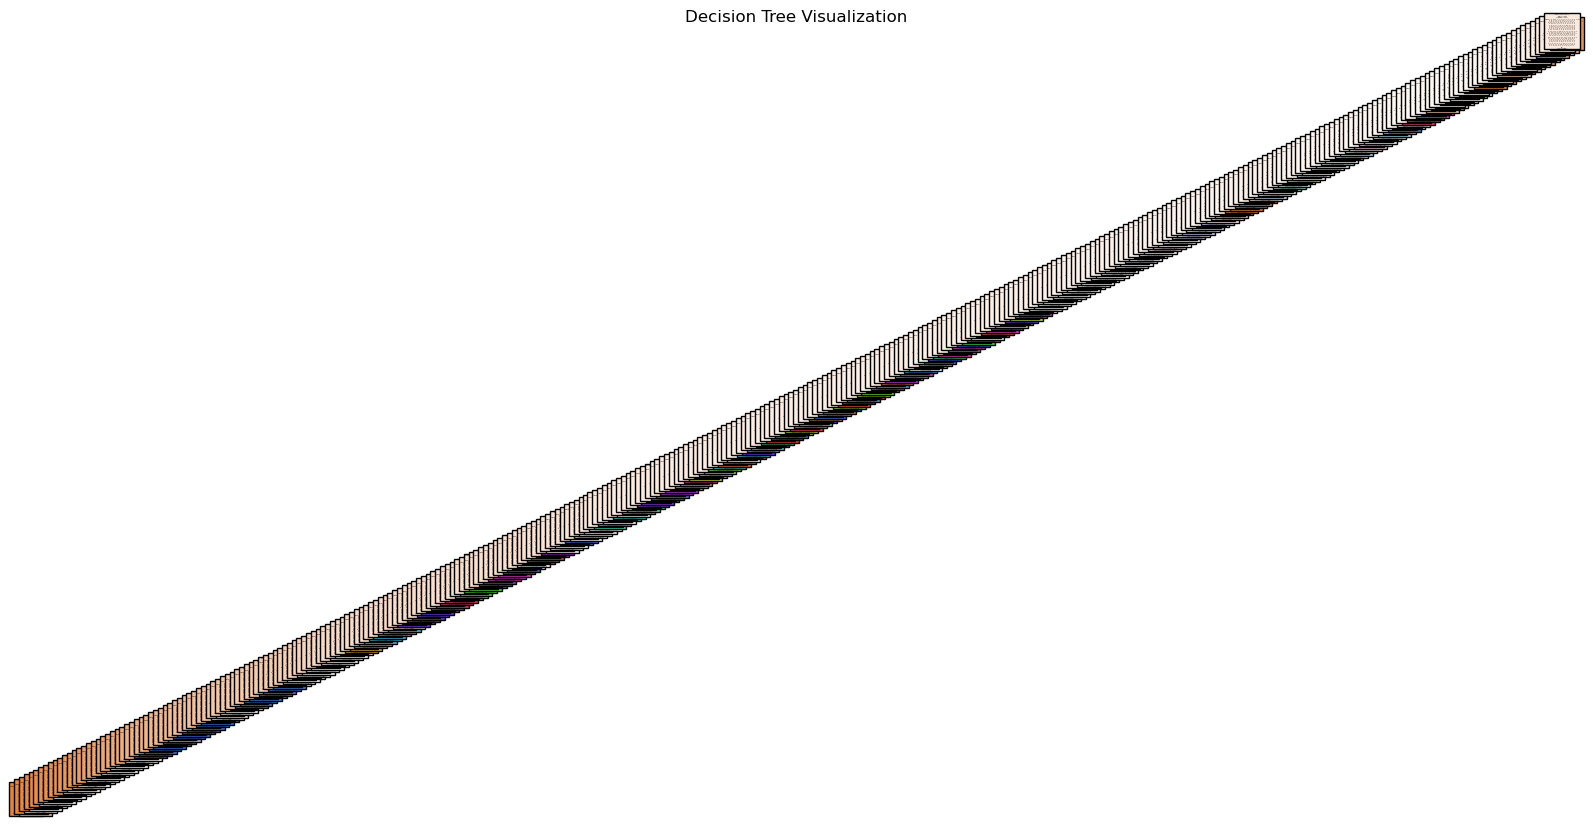

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Convert feature names from NumPy array to list
feature_names_list = mlb.classes_.tolist()

# Generate a list of unique class names from the target variable 'y'
class_names_list = y.unique().tolist()

# Assuming 'tree' is your trained Decision Tree model from previous code
plt.figure(figsize=(20, 10))  # Set the size of the figure
plot_tree(tree, filled=True, feature_names=feature_names_list, class_names=class_names_list)
plt.title('Decision Tree Visualization')
plt.show()
